<a href="https://colab.research.google.com/github/UznetDev/Competition-for-NT-4th-month/blob/main/Competition_for_NT_4th_month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import


In [ ]:
!pip install phik

In [ ]:
import pandas as pd
import numpy as np
import phik
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.ensemble import *
from imblearn.over_sampling import *
from sklearn.naive_bayes import *
from sklearn.tree import *
from sklearn.feature_selection import *

## Get data

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df = train_df.drop(columns=['id'])

In [ ]:
test_df.head(1)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.0,2,0.0,1.0,160976.75


In [ ]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


- **Surname**: Mijozning familiyasi.
- **Geography**: Mijoz yashaydigan mamlakat.
- **Gender**: Mijozning jinsi.
- **HasCrCard**: Kredit kartaga ega yoki yo‘qligi (1 = ega, 0 = ega emas).
- **IsActiveMember**: Faol a'zo yoki yo‘qligi (1 = faol, 0 = faol emas).
- **Exited**: Mijoz bankni tark etgan yoki yo‘qligi (1 = tark etgan, 0 = qolgan).
- **id**: Har bir yozuv uchun noyob identifikator.
- **CustomerId**: Mijozning noyob identifikatori.
- **CreditScore**: Kredit balli.
- **Age**: Mijozning yoshi.
- **Tenure**: Bank bilan bo‘lgan yillar soni.
- **Balance**: Mijozning hisob balansidagi mablag‘.
- **NumOfProducts**: Mijoz foydalanayotgan bank mahsulotlari soni.
- **EstimatedSalary**: Mijozning taxminiy daromadi.

## Function

In [ ]:
def get_WoE(data, feature_name, target_name, sort=False):
    df = data.copy()
    df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})
    df['Percentage events'] = df['# of events'] / df['# of events'].sum()
    df['Percentage non-events'] = df['# of non-events'] / df['# of non-events'].sum()
    df['WOE'] = np.log(df['Percentage events'] / df['Percentage non-events'])

    df['Total Observations'] = df['# of events'] + df['# of non-events']
    df['Percent of Observations'] = (df['Total Observations'] / \
                                            df['Total Observations'].sum() * 100).round(3)
    df['rank'] = df['WOE'].rank()
    if sort:
        df = df.sort_values('WOE')
    return df.reset_index()



def view_WoE(woe_df: pd.DataFrame, cat, plotly=True) -> go.Figure:
    if isinstance(woe_df, pd.DataFrame):
      if plotly:
          x = woe_df.index.astype(str)
          fig = go.Figure()
          fig.add_trace(go.Bar(
              x=x,
              y=woe_df['WOE'],
              name='WOE',
              yaxis='y1'
          ))

          fig.add_trace(go.Scatter(
              x=x,
              y=woe_df['WOE'],
              name='Weight of Evidence',
              mode='lines+markers',
              marker=dict(color='red'),
              yaxis='y1'
          ))

          fig.add_trace(go.Scatter(
              x=x,
              y=woe_df['rank'],
              name='Percent of Observations',
              mode='lines+markers',
              marker=dict(color='green'),
              yaxis='y2'
          ))
          fig.update_layout(
              yaxis=dict(
                  title="WOE",
                  showgrid=False
              ),
              yaxis2=dict(
                  title="Percent of Observations",
                  overlaying='y',
                  side='right',
                  showgrid=False
              ),
              xaxis=dict(
                  title="Category"
              ),
              title="WOE and Rank Graphs"
          )

          return fig
      else:
          fig, ax1 = plt.subplots(figsize=(10, 6))
          ax2 = ax1.twinx()

          sns.pointplot(data=woe_df, x=cat, y='WOE', color='red', linewidth=2, ax=ax1)
          ax1.set_ylabel('Weight of Evidence (WoE)', color='red')
          ax1.tick_params(axis='y', colors='red')
          ax1.set_xlabel('Categories')
          for label in ax1.get_xticklabels():
              label.set_rotation(90)
          sns.barplot(data=woe_df, x=cat, y='Percent of Observations', alpha=0.3, ax=ax2)
          ax2.set_ylabel('Rate of Observations')
          ax2.set_ylim(0, woe_df['Percent of Observations'].max() * 1.2)
          ax2.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
          ax1.grid(visible=True, which='major', linestyle='--')
          plt.title("WoE change plot")
          plt.show()
    else:
        return woe_df


def plot_histograms(train_df, test_df, cat, rank, rotation=40):
    fig, ax = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

    sns.histplot(data=train_df[rank].astype(str), kde=True, ax=ax[0][0])
    ax[0][0].set_title(f'{rank} in Train')
    sns.histplot(data=train_df[cat].astype(str), kde=True, ax=ax[0][1])
    ax[0][1].set_title(f'{cat} in Train')

    sns.histplot(data=test_df[rank].astype(str), kde=True, ax=ax[1][0])
    ax[1][0].set_title(f'{rank} in Test')
    sns.histplot(data=test_df[cat].astype(str), kde=True, ax=ax[1][1])
    ax[1][1].set_title(f'{cat} in Test')

    for axes in ax.flat:
        axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)

    plt.tight_layout()
    plt.show()

In [ ]:
train_df.head(1)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0


In [ ]:
age_ps, p_value = stats.pointbiserialr(train_df['Exited'], train_df['Age'])
CreditScore_ps, p_value = stats.pointbiserialr(train_df['Exited'], train_df['CreditScore'])
EstimatedSalary_ps, p_value = stats.pointbiserialr(train_df['Exited'], train_df['EstimatedSalary'])
Balance_ps, p_value = stats.pointbiserialr(train_df['Exited'], train_df['Balance'])
NumOfProducts_ps, p_value = stats.pointbiserialr(train_df['Exited'], train_df['NumOfProducts'])
Tenure_ps, p_value = stats.pointbiserialr(train_df['Exited'], train_df['Tenure'])

text = f"""
Age: {round(age_ps, 3)} (p-value: {round(p_value, 3)})\n
CreditScore: {round(CreditScore_ps, 3)} (p-value: {round(p_value, 3)})\n
EstimatedSalary: {round(EstimatedSalary_ps, 3)} (p-value: {round(p_value, 3)})\n
Balance: {round(Balance_ps, 3)} (p-value: {round(p_value, 3)})\n
NumOfProducts: {round(NumOfProducts_ps, 3)} (p-value: {round(p_value, 3)})\n
Tenure: {round(Tenure_ps, 3)} (p-value: {round(p_value, 3)})
"""
print(text)


Age: 0.341 (p-value: 0.0)

CreditScore: -0.027 (p-value: 0.0)

EstimatedSalary: 0.019 (p-value: 0.0)

Balance: 0.13 (p-value: 0.0)

NumOfProducts: -0.215 (p-value: 0.0)

Tenure: -0.02 (p-value: 0.0)



In [ ]:
train_df[['HasCrCard', 'IsActiveMember', 'Exited']].phik_matrix()

interval columns not set, guessing: ['HasCrCard', 'IsActiveMember', 'Exited']


,HasCrCard,IsActiveMember,Exited
HasCrCard,1.000000,0.032783,0.034529
IsActiveMember,0.032783,1.000000,0.324228
Exited,0.034529,0.324228,1.000000


# Feature engening

## Age

<Axes: xlabel='Age', ylabel='Count'>

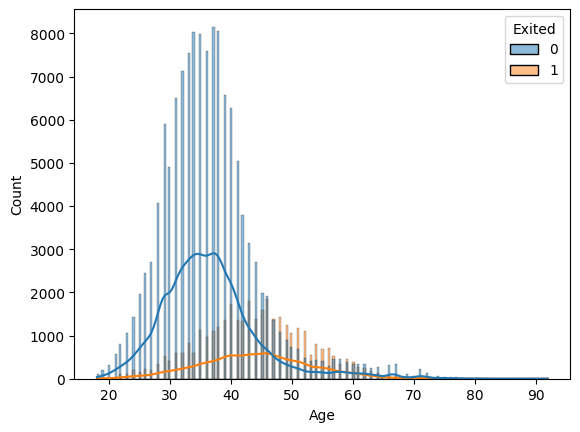

In [ ]:
sns.histplot(data=train_df, x='Age', hue='Exited', kde=True)

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



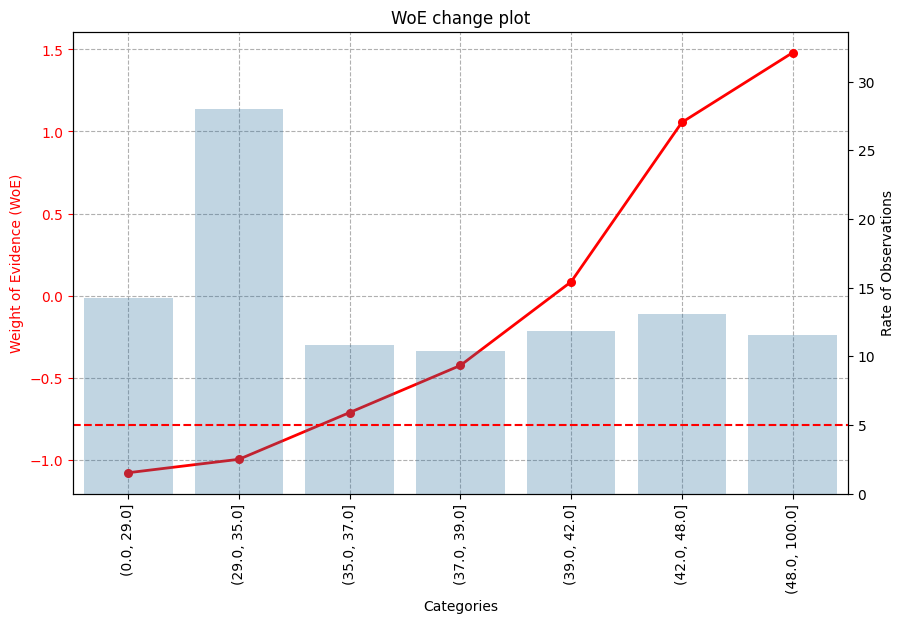

In [ ]:
train_df['age_cat'] = pd.cut(train_df['Age'], bins=[0, 29.0, 35.0, 37.00, 39.00, 42.0, 48.0, 100.0])
test_df['age_cat'] = pd.cut(test_df['Age'], bins=[0, 29.0, 35.0, 37.00, 39.00, 42.0, 48.0, 100.0])
woe_table = get_WoE(train_df, 'age_cat', 'Exited')
view_WoE(woe_table,cat='age_cat', plotly=False)

In [ ]:
# train_df['age_rank'] = pd.merge(train_df, woe_df[['age_cat', 'rank']], on='age_cat', how='left')['rank']
rank_dict = woe_table.set_index('age_cat')['rank'].to_dict()
train_df['age_rank'] = train_df['age_cat'].map(rank_dict)
test_df['age_rank'] = test_df['age_cat'].map(rank_dict)
train_df['age_rank'] = pd.to_numeric(train_df['age_rank'])
test_df['age_rank'] = pd.to_numeric(test_df['age_rank'])

woe_dict = woe_table.set_index('age_cat')['WOE'].to_dict()
train_df['age_woe'] = train_df['age_cat'].map(woe_dict)
test_df['age_woe'] = test_df['age_cat'].map(woe_dict)
train_df['age_woe'] = pd.to_numeric(train_df['age_woe'])
test_df['age_woe'] = pd.to_numeric(test_df['age_woe'])

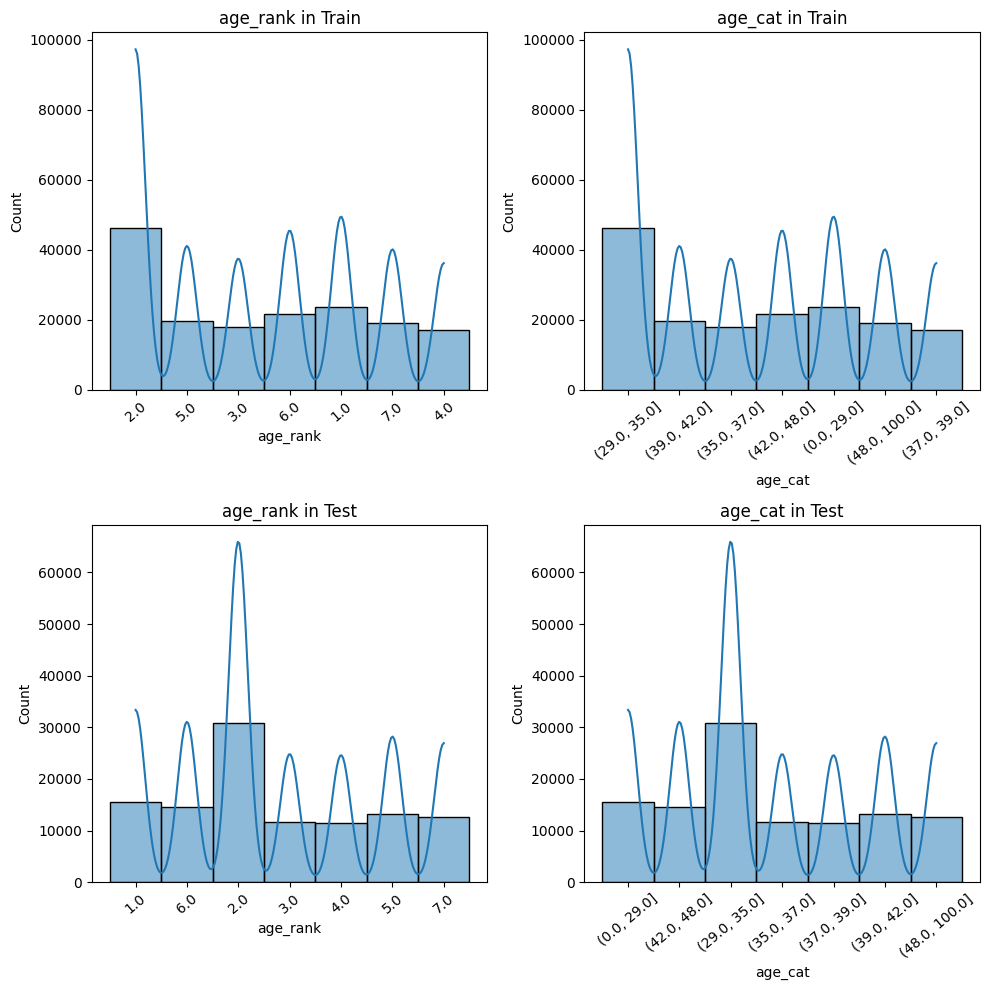

In [ ]:
plot_histograms(train_df, test_df, 'age_cat', 'age_rank')

In [ ]:
# age_bins = pd.IntervalIndex(train_df['age_cat'].cat.categories)
# test_df['age_cat'] = pd.cut(test_df['Age'], bins=age_bins)
# age_rank_map = train_df[['age_cat', 'age_rank']].drop_duplicates().set_index('age_cat')['age_rank'].to_dict()
# test_df['age_rank'] = test_df['age_cat'].map(age_rank_map)
# test_df.drop(columns=['age_cat'], inplace=True)
# train_df.drop(columns=['age_cat'], inplace=True)

In [ ]:
train_df['balance_cat'] = pd.qcut(train_df['Balance'], q=10, duplicates='drop')
test_df['balance_cat'] = pd.qcut(test_df['Balance'], q=10, duplicates='drop')

woe_df = get_WoE(train_df, 'balance_cat', 'Exited')

view_WoE(woe_df, cat='balance_cat', plotly=True)

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



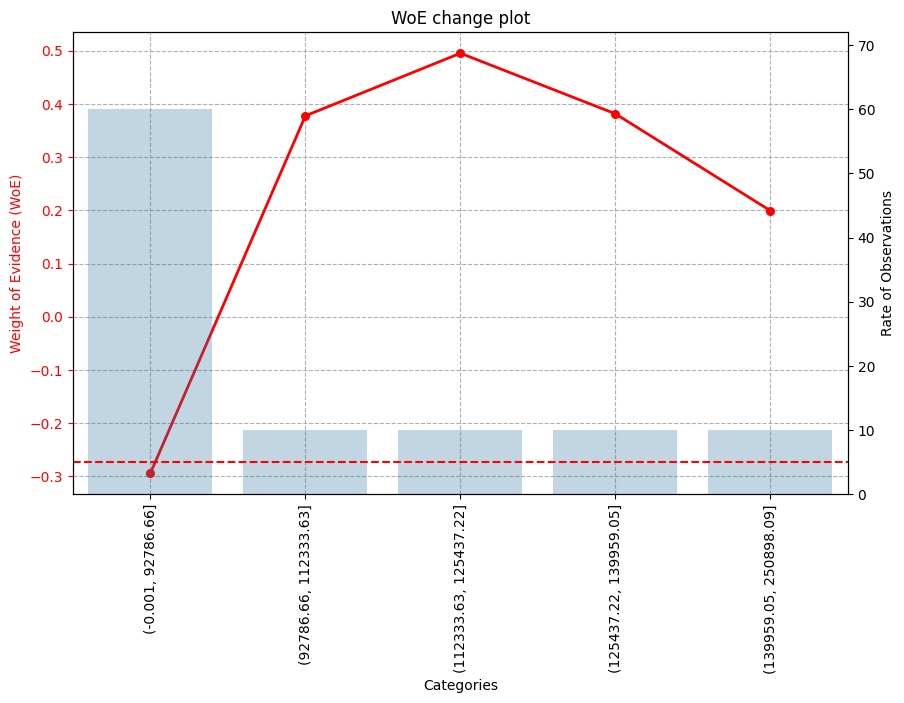

In [ ]:
view_WoE(woe_df, cat='balance_cat', plotly=False)

In [ ]:
train_df.head(1)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_cat,age_rank,age_woe,balance_cat
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0,"(29.0, 35.0]",2.0,-0.997948,"(-0.001, 92786.66]"


## NumOfProducts

<Axes: xlabel='NumOfProducts', ylabel='Exited'>

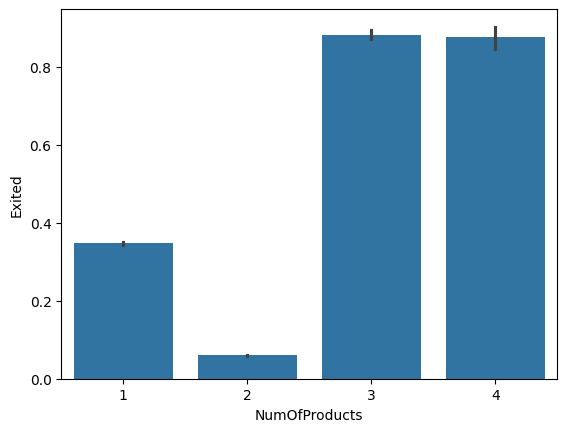

In [ ]:
sns.barplot(data=train_df, x='NumOfProducts', y='Exited')

In [ ]:
woe_df = get_WoE(train_df, 'NumOfProducts', 'Exited')
view_WoE(woe_df, cat='NumOfProducts', plotly=True)

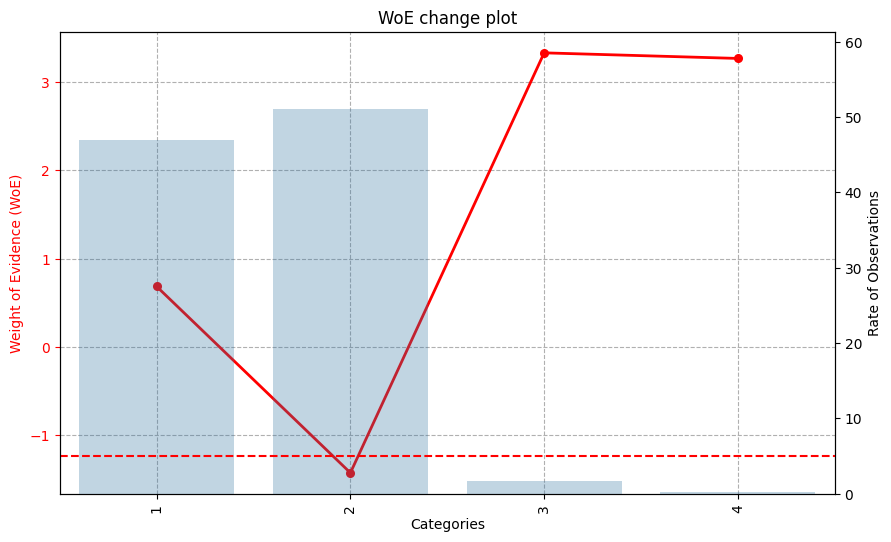

In [ ]:
woe_df = get_WoE(train_df, 'NumOfProducts', 'Exited')
view_WoE(woe_df, cat='NumOfProducts', plotly=False)

In [ ]:
train_df.head(1)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_cat,age_rank,age_woe,balance_cat
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0,"(29.0, 35.0]",2.0,-0.997948,"(-0.001, 92786.66]"


## Geography

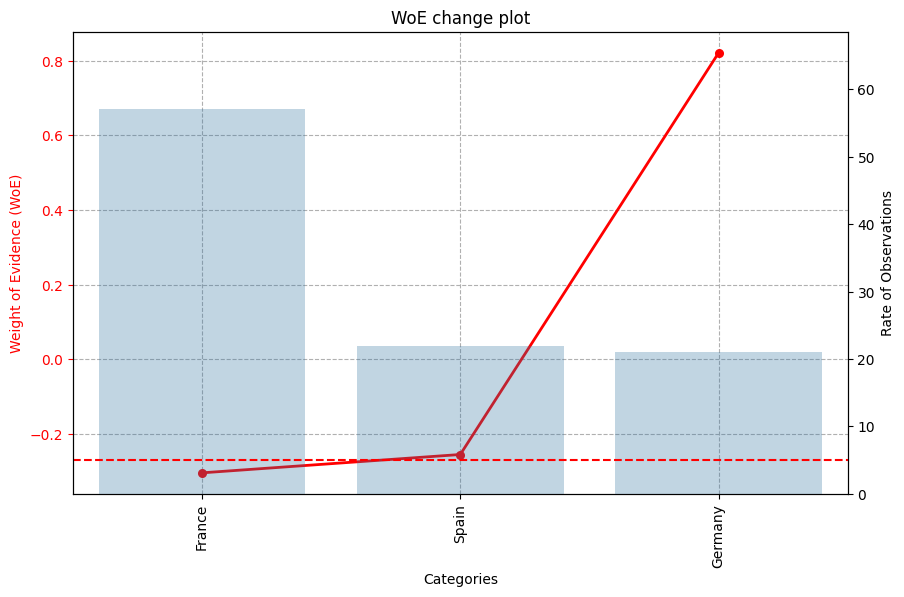

In [ ]:
geo_woe = get_WoE(train_df, 'Geography', 'Exited', sort=True)
view_WoE(geo_woe, cat='Geography', plotly=False)

In [ ]:
new_rank_dict = geo_woe.set_index('Geography')['rank'].to_dict()
train_df['geo_rank'] = train_df['Geography'].map(new_rank_dict)
test_df['geo_rank'] = test_df['Geography'].map(new_rank_dict)
train_df['geo_rank'] = pd.to_numeric(train_df['geo_rank'])
test_df['geo_rank'] = pd.to_numeric(test_df['geo_rank'])

woe_dict = geo_woe.set_index('Geography')['WOE'].to_dict()
train_df['geo_woe'] = train_df['Geography'].map(woe_dict)
test_df['geo_woe'] = test_df['Geography'].map(woe_dict)
train_df['geo_woe'] = pd.to_numeric(train_df['geo_woe'])
test_df['geo_woe'] = pd.to_numeric(test_df['geo_woe'])

In [ ]:
lbl = LabelEncoder()
train_df['Geography'] = lbl.fit_transform(train_df['Geography'])
test_df['Geography'] = lbl.fit_transform(test_df['Geography'])

In [ ]:
train_df.head(1)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_cat,age_rank,age_woe,balance_cat,geo_rank,geo_woe
0,15674932,Okwudilichukwu,668,0,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0,"(29.0, 35.0]",2.0,-0.997948,"(-0.001, 92786.66]",1.0,-0.304129


## CreditScore

In [ ]:
# bins = [349.999, 554.0, 587.0, 613.0, 638.0, 681.0, 701.0, 721.0, 754.0, 850.0]

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



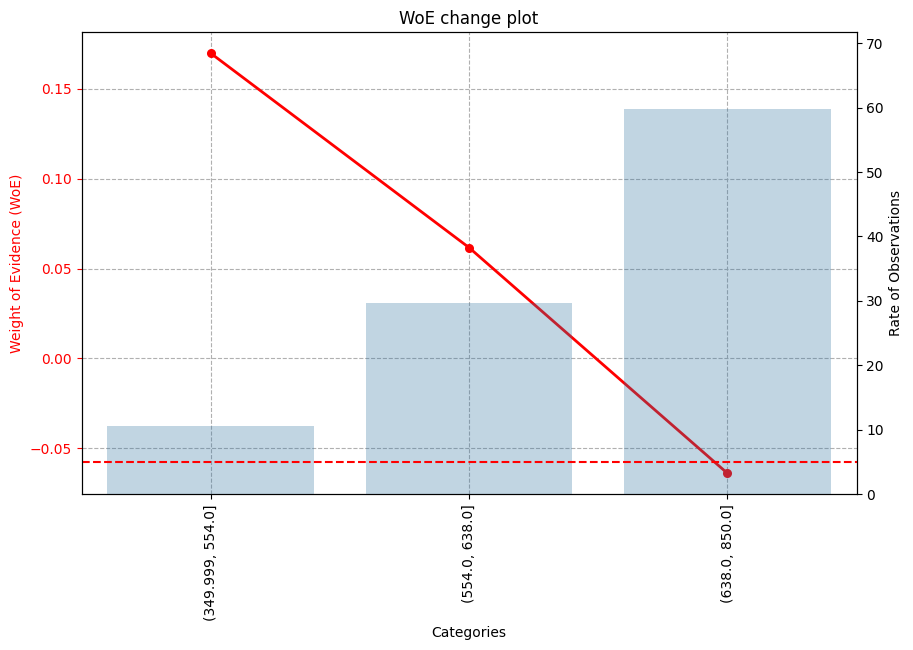

In [ ]:
# train_df['credit_score_cat'] = pd.qcut(train_df['CreditScore'], q=10, duplicates='drop')
bins = [349.999, 554.0, 638.0, 850.0]
train_df['credit_score_cat'] = pd.cut(train_df['CreditScore'], bins=bins)
test_df['credit_score_cat'] = pd.cut(test_df['CreditScore'], bins=bins)
cs_woe = get_WoE(train_df, 'credit_score_cat', 'Exited', sort=True)
view_WoE(cs_woe, cat='credit_score_cat', plotly=False)

In [ ]:
credit_score_rank_map = cs_woe.set_index('credit_score_cat')['rank'].to_dict()
train_df['credit_score_rank'] = train_df['credit_score_cat'].map(credit_score_rank_map)
test_df['credit_score_rank'] = test_df['credit_score_cat'].map(credit_score_rank_map)
train_df['credit_score_rank'] = pd.to_numeric(train_df['credit_score_rank'])
test_df['credit_score_rank'] = pd.to_numeric(test_df['credit_score_rank'])

credit_score_woe = cs_woe.set_index('credit_score_cat')['WOE'].to_dict()
train_df['credit_score_woe'] = train_df['credit_score_cat'].map(credit_score_woe)
test_df['credit_score_woe'] = test_df['credit_score_cat'].map(credit_score_woe)
train_df['credit_score_woe'] = pd.to_numeric(train_df['credit_score_woe'])
test_df['credit_score_woe'] = pd.to_numeric(test_df['credit_score_woe'])

<ipython-input-89-8900af3621a6>:100: UserWarning:

FixedFormatter should only be used together with FixedLocator



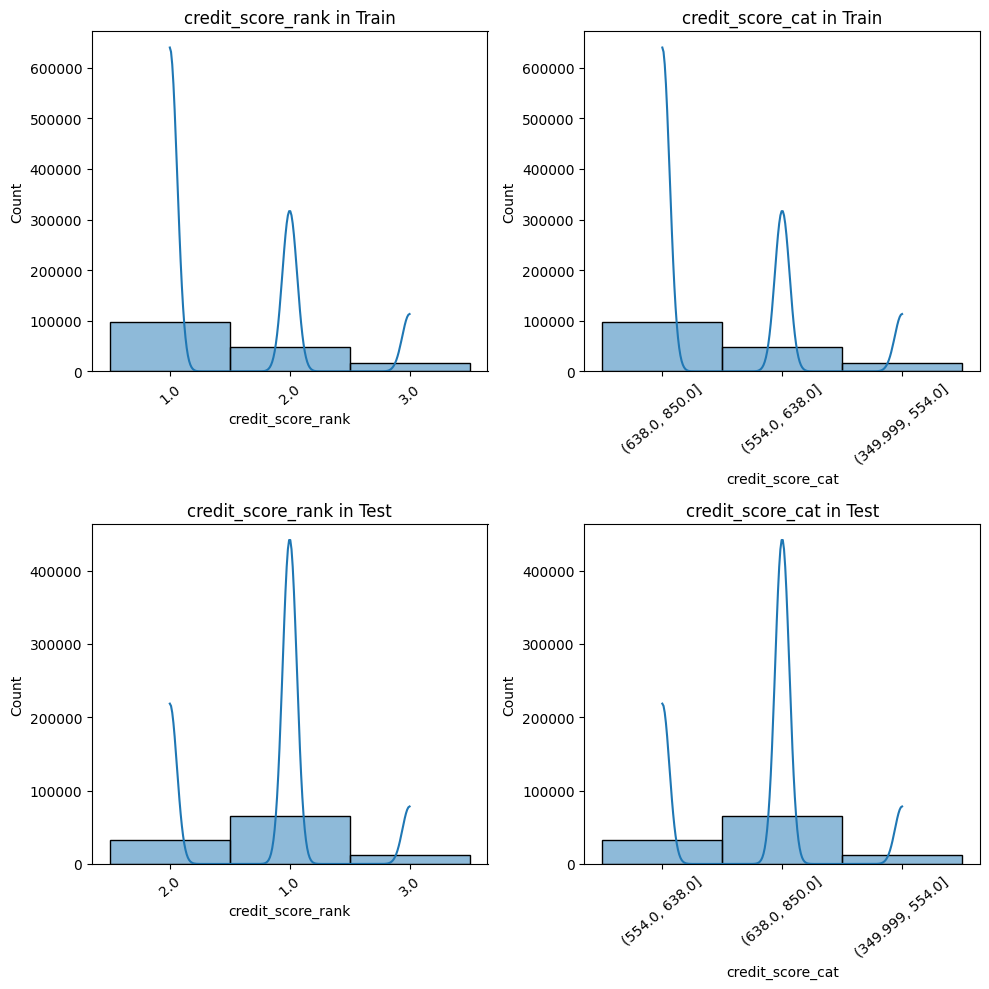

In [ ]:
plot_histograms(train_df, test_df, 'credit_score_cat', 'credit_score_rank')

In [ ]:
# train_df['credit_score_rank'] = pd.merge(train_df, cs_woe[['credit_score_cat', 'rank']], on='credit_score_cat', how='left')['rank']
# age_bins = pd.IntervalIndex(train_df['credit_score_cat'].cat.categories)
# test_df['credit_score_cat'] = pd.cut(test_df['CreditScore'], bins=age_bins)
# age_rank_map = train_df[['credit_score_cat', 'credit_score_rank']].drop_duplicates().set_index('credit_score_cat')['credit_score_rank'].to_dict()
# test_df['credit_score_rank'] = test_df['credit_score_cat'].map(age_rank_map)

# train_df.drop(columns=['credit_score_cat'], inplace=True)
# test_df.drop(columns=['credit_score_cat'], inplace=True)

## Tenure

<Axes: xlabel='Tenure', ylabel='Count'>

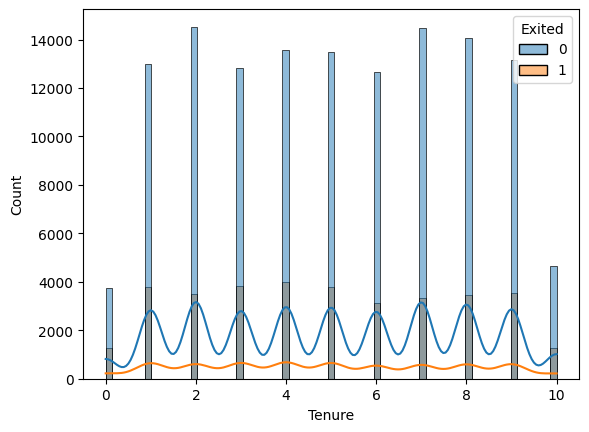

In [ ]:
sns.histplot(data=train_df, x='Tenure', hue='Exited', kde=True)

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



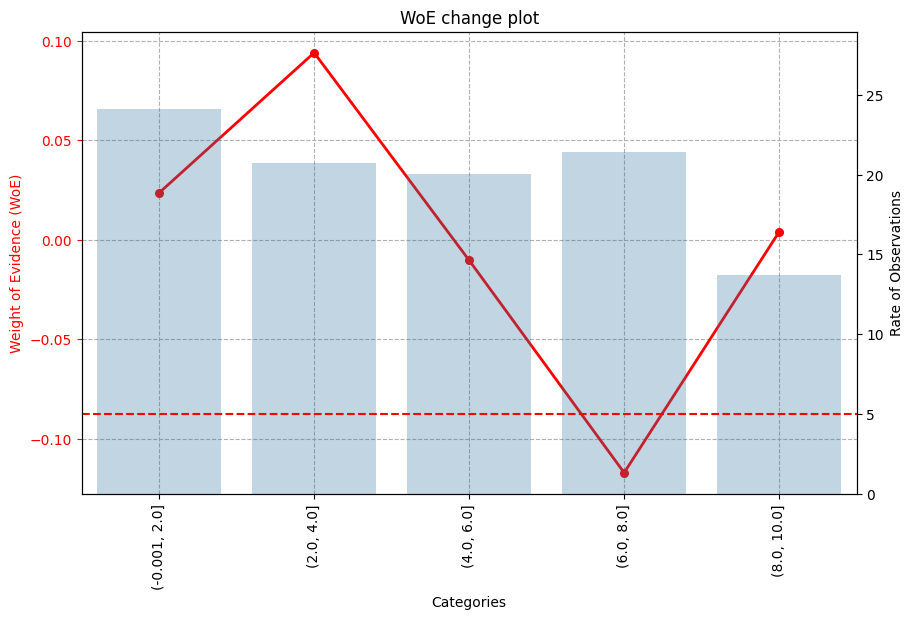

In [ ]:
train_df['tenure_cat'] = pd.qcut(train_df['Tenure'], q=5, duplicates='drop')

woe_df = get_WoE(train_df, 'tenure_cat', 'Exited')
view_WoE(woe_df, cat='tenure_cat', plotly=False)

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



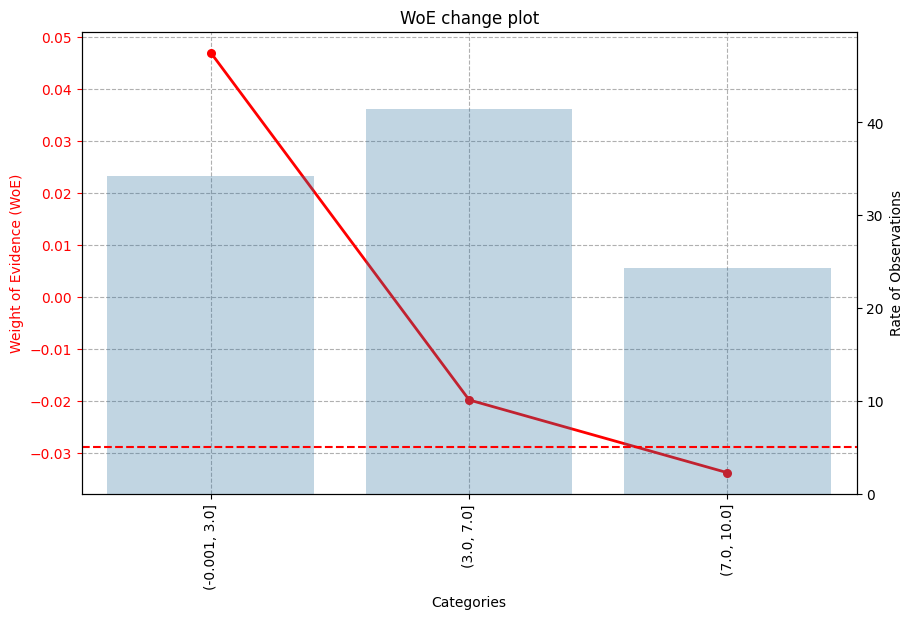

In [ ]:
train_df['tenure_cat'] = pd.qcut(train_df['Tenure'], q=3, duplicates='drop')

woe_df = get_WoE(train_df, 'tenure_cat', 'Exited')
view_WoE(woe_df, cat='tenure_cat', plotly=False)

In [ ]:
bins = [-0.001, 3.0, 7.0, 10.0]

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



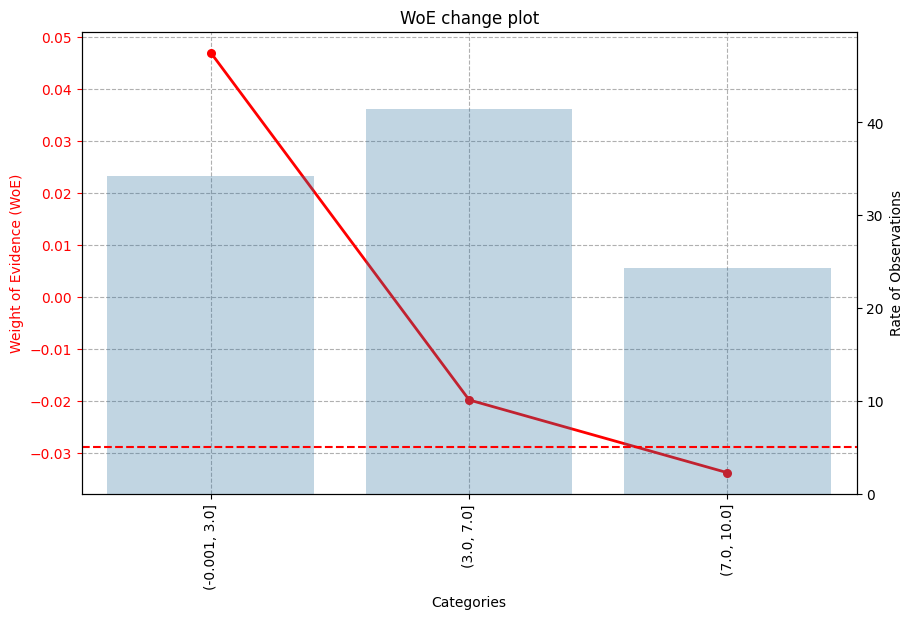

In [ ]:
train_df['tenure_cat'] = pd.cut(train_df['Tenure'], bins=bins)
test_df['tenure_cat'] = pd.cut(test_df['Tenure'], bins=bins)

woe_df = get_WoE(train_df, 'tenure_cat', 'Exited')
view_WoE(woe_df, cat='tenure_cat', plotly=False)

In [ ]:
tenure_rank_map = woe_df.set_index('tenure_cat')['rank'].to_dict()
train_df['tenure_rank'] = train_df['tenure_cat'].map(tenure_rank_map)
test_df['tenure_rank'] = test_df['tenure_cat'].map(tenure_rank_map)
train_df['tenure_rank'] = pd.to_numeric(train_df['tenure_rank'])
test_df['tenure_rank'] = pd.to_numeric(test_df['tenure_rank'])

woe_dict = woe_df.set_index('tenure_cat')['WOE'].to_dict()
train_df['tenure_woe'] = train_df['tenure_cat'].map(woe_dict)
test_df['tenure_woe'] = test_df['tenure_cat'].map(woe_dict)
train_df['tenure_woe'] = pd.to_numeric(train_df['tenure_woe'])
test_df['tenure_woe'] = pd.to_numeric(test_df['tenure_woe'])

<ipython-input-89-8900af3621a6>:100: UserWarning:

FixedFormatter should only be used together with FixedLocator



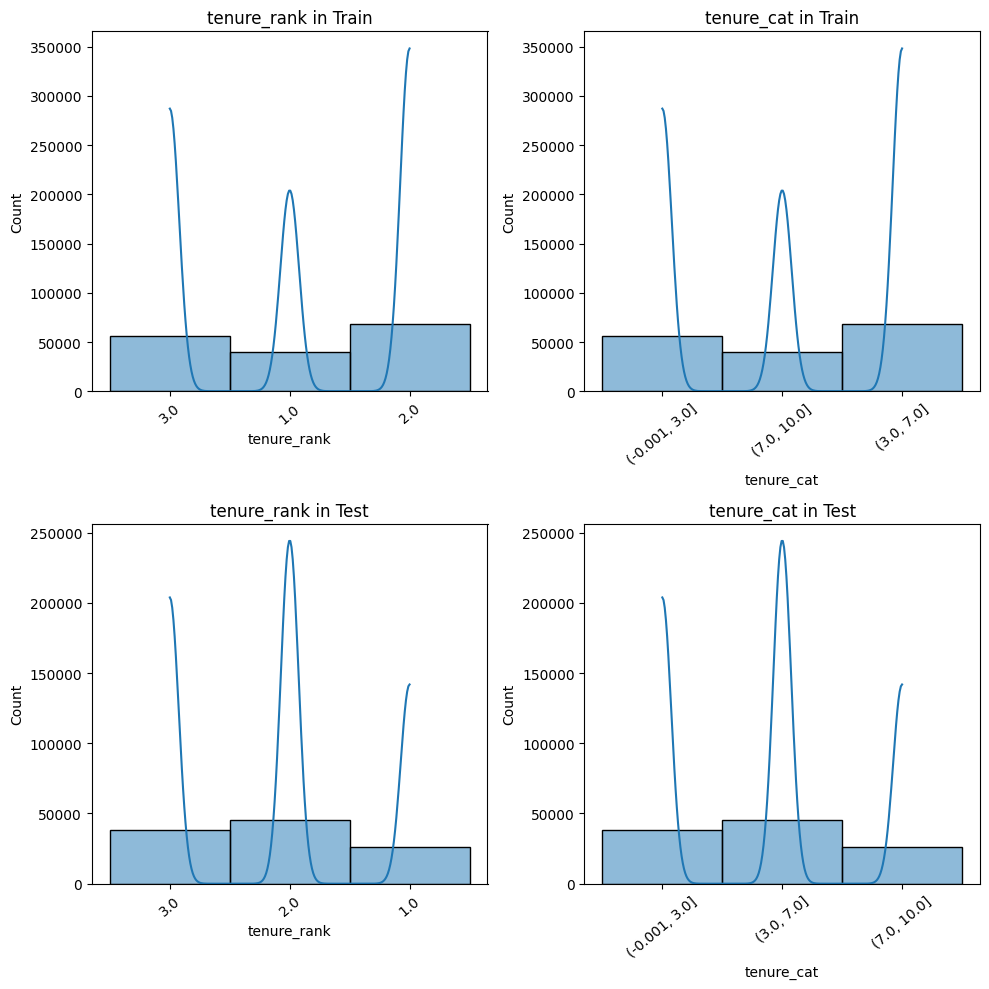

In [ ]:
plot_histograms(train_df, test_df, 'tenure_cat', 'tenure_rank')

In [ ]:
train_df.head(1)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,age_woe,balance_cat,geo_rank,geo_woe,credit_score_cat,credit_score_rank,credit_score_woe,tenure_cat,tenure_rank,tenure_woe
0,15674932,Okwudilichukwu,668,0,Male,33.0,3,0.0,2,1.0,...,-0.997948,"(-0.001, 92786.66]",1.0,-0.304129,"(638.0, 850.0]",1.0,-0.06392,"(-0.001, 3.0]",3.0,0.047041


## NumOfProducts

<Axes: xlabel='NumOfProducts', ylabel='Count'>

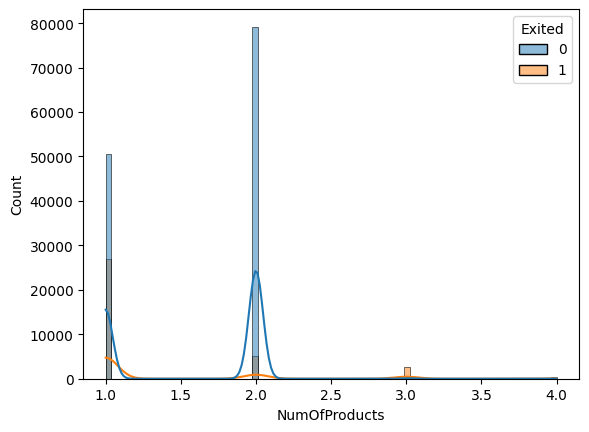

In [ ]:
sns.histplot(data=train_df, x='NumOfProducts', hue='Exited', kde=True)

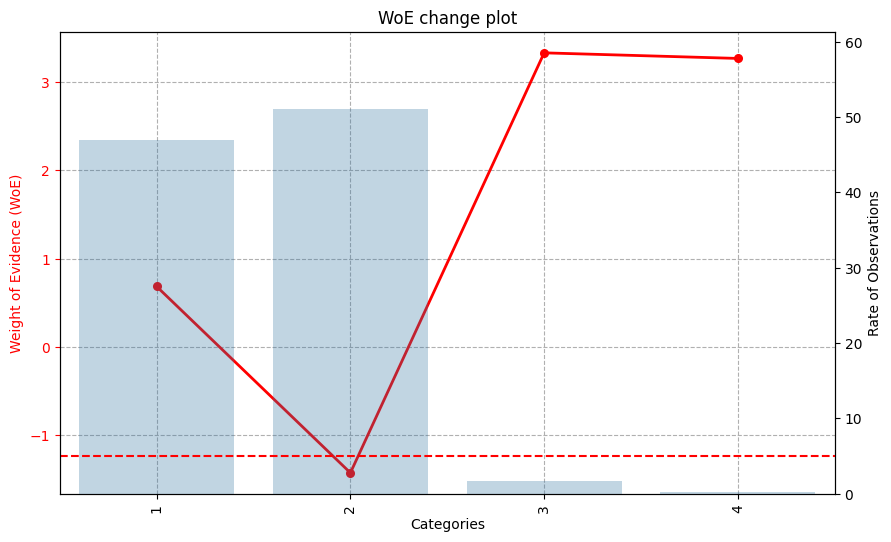

In [ ]:
# train_df['num_products_cat'] = pd.qcut(train_df['NumOfProducts'], q=10, duplicates='drop')
woe_df = get_WoE(train_df, 'NumOfProducts', 'Exited')
view_WoE(woe_df, cat='NumOfProducts', plotly=False)

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



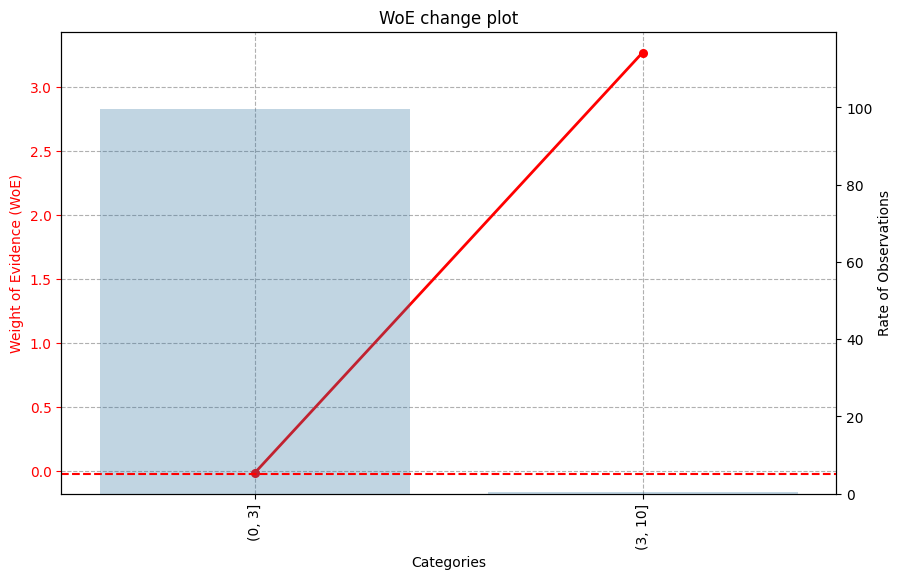

In [ ]:
bins = [0, 3, 10]
train_df['num_products_cat'] = pd.cut(train_df['NumOfProducts'], bins=bins)
test_df['num_products_cat'] = pd.cut(test_df['NumOfProducts'], bins=bins)
woe_df = get_WoE(train_df, 'num_products_cat', 'Exited')
view_WoE(woe_df, cat='num_products_cat', plotly=False)

In [ ]:
# nu_product_rank_map = woe_df.set_index('num_products_cat')['rank'].to_dict()
# train_df['num_products_rank'] = train_df['num_products_cat'].map(nu_product_rank_map)
# test_df['num_products_rank'] = test_df['num_products_cat'].map(nu_product_rank_map)

# woe_dict = woe_df.set_index('num_products_cat')['WOE'].to_dict()
# train_df['num_products_woe'] = train_df['num_products_cat'].map(woe_dict)
# test_df['num_products_woe'] = test_df['num_products_cat'].map(woe_dict)
# plot_histograms(train_df, test_df, 'num_products_cat', 'num_products_rank')

## EstimatedSalary


<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



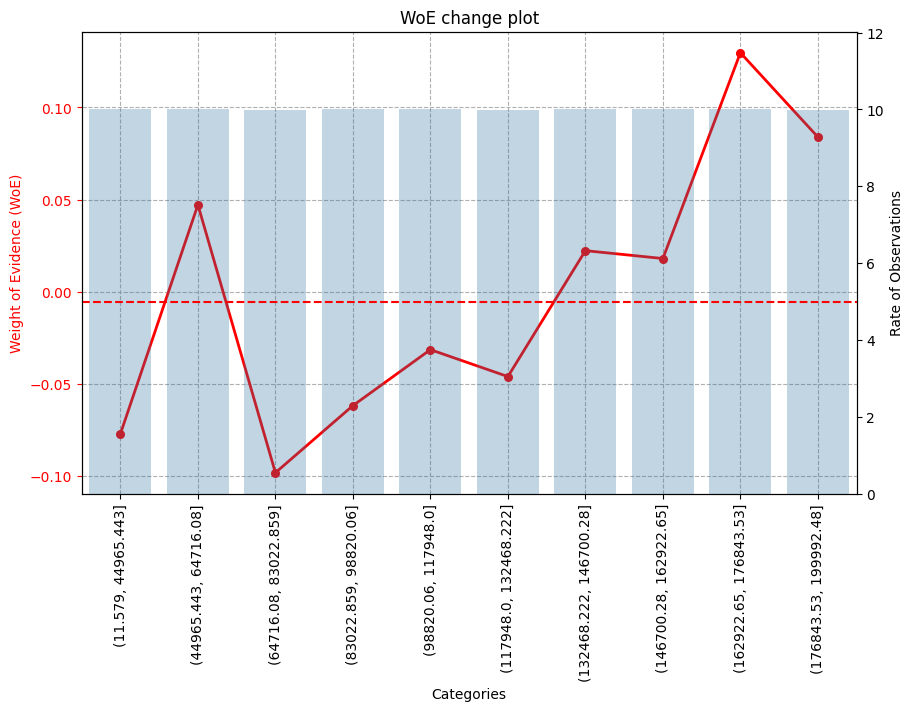

In [ ]:
train_df['salary_cat'] = pd.qcut(train_df['EstimatedSalary'], q=10, duplicates='drop')

woe_df = get_WoE(train_df, 'salary_cat', 'Exited')
view_WoE(woe_df, cat='salary_cat', plotly=False)

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



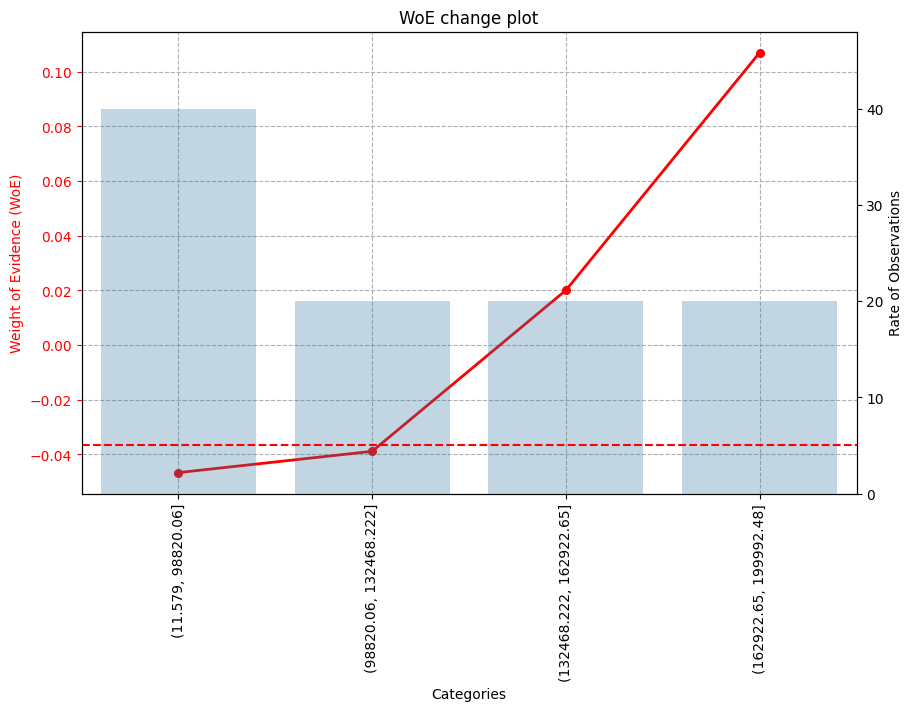

In [ ]:
bins = [11.579, 98820.06, 132468.222, 162922.65, 199992.48]
train_df['salary_cat'] = pd.cut(train_df['EstimatedSalary'], bins=bins)
test_df['salary_cat'] = pd.cut(test_df['EstimatedSalary'], bins=bins)
woe_df = get_WoE(train_df, 'salary_cat', 'Exited')
view_WoE(woe_df, cat='salary_cat', plotly=False)

<ipython-input-89-8900af3621a6>:100: UserWarning:

FixedFormatter should only be used together with FixedLocator



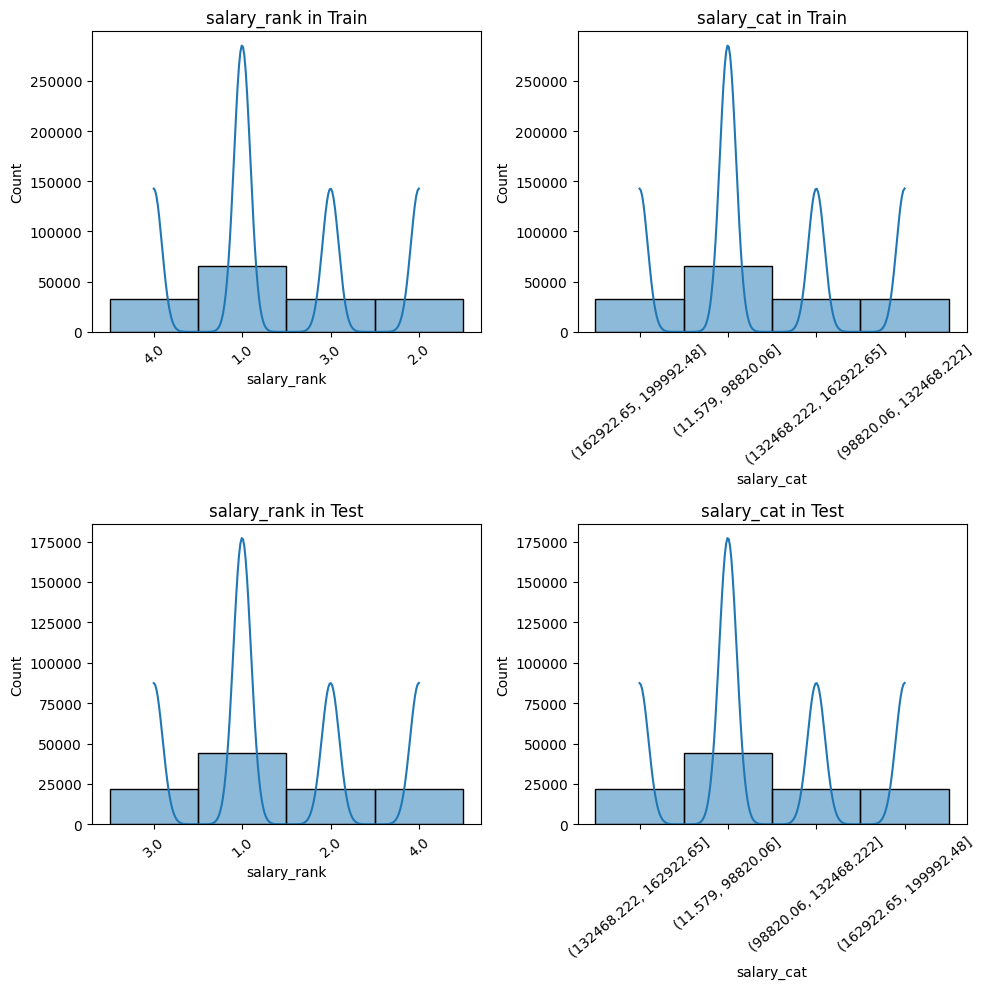

In [ ]:
salary_rank_map = woe_df.set_index('salary_cat')['rank'].to_dict()
train_df['salary_rank'] = train_df['salary_cat'].map(salary_rank_map)
test_df['salary_rank'] = test_df['salary_cat'].map(salary_rank_map)
train_df['salary_rank'] = pd.to_numeric(train_df['salary_rank'])
test_df['salary_rank'] = pd.to_numeric(test_df['salary_rank'])

woe_dict = woe_df.set_index('salary_cat')['WOE'].to_dict()
train_df['salary_woe'] = train_df['salary_cat'].map(woe_dict)
test_df['salary_woe'] = test_df['salary_cat'].map(woe_dict)
plot_histograms(train_df, test_df, 'salary_cat', 'salary_rank')
train_df['salary_woe'] = pd.to_numeric(train_df['salary_woe'])
test_df['salary_woe'] = pd.to_numeric(test_df['salary_woe'])

In [ ]:
train_df.head(1)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,credit_score_cat,credit_score_rank,credit_score_woe,tenure_cat,tenure_rank,tenure_woe,num_products_cat,salary_cat,salary_rank,salary_woe
0,15674932,Okwudilichukwu,668,0,Male,33.0,3,0.0,2,1.0,...,"(638.0, 850.0]",1.0,-0.06392,"(-0.001, 3.0]",3.0,0.047041,"(0, 3]","(162922.65, 199992.48]",4.0,0.107029


## Balance

In [ ]:
# pd.IntervalIndex(train_df['balance_cat'].cat.categories)

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



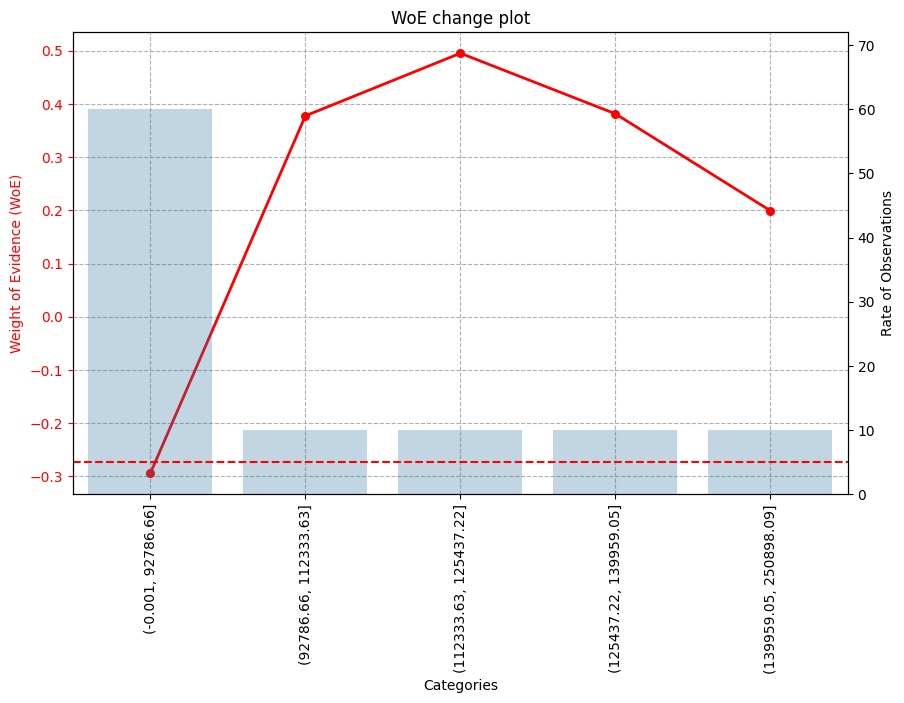

In [ ]:
train_df['balance_cat'] = pd.qcut(train_df['Balance'], q=10, duplicates='drop')

woe_df = get_WoE(train_df, 'balance_cat', 'Exited')
view_WoE(woe_df, cat='balance_cat', plotly=False)

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



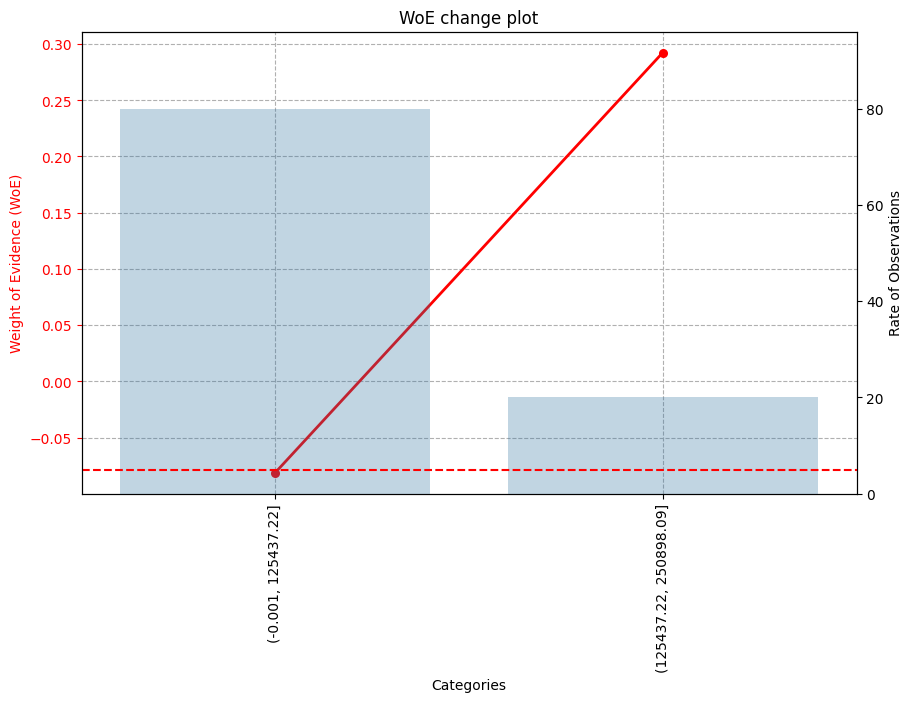

In [ ]:
bins = [-0.001,  125437.22, 250898.09]
train_df['balance_cat'] = pd.cut(train_df['Balance'], bins=bins)
test_df['balance_cat'] = pd.cut(test_df['Balance'], bins=bins)

woe_df = get_WoE(train_df, 'balance_cat', 'Exited')
view_WoE(woe_df, cat='balance_cat', plotly=False)

<ipython-input-89-8900af3621a6>:100: UserWarning:

FixedFormatter should only be used together with FixedLocator



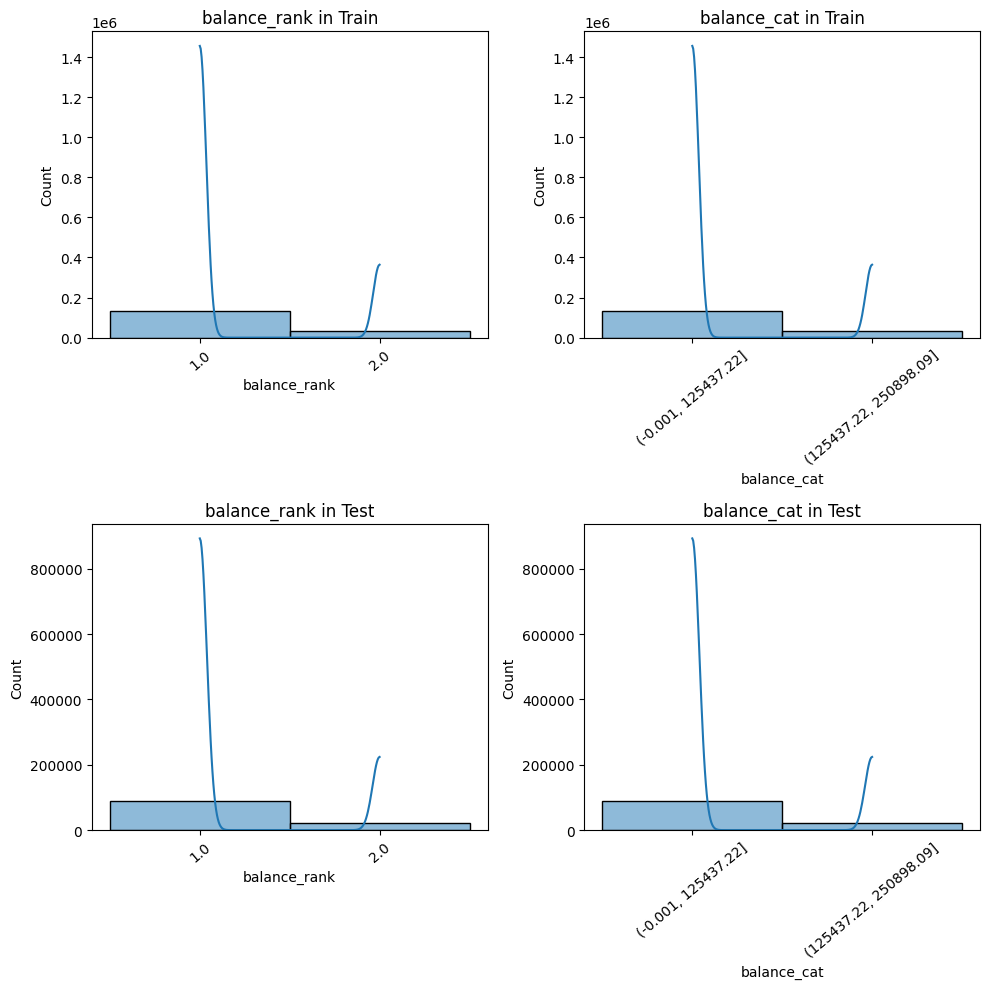

In [ ]:
balance_rank_map = woe_df.set_index('balance_cat')['rank'].to_dict()
train_df['balance_rank'] = train_df['balance_cat'].map(balance_rank_map)
test_df['balance_rank'] = test_df['balance_cat'].map(balance_rank_map)
train_df['balance_rank'] = pd.to_numeric(train_df['balance_rank'])
test_df['balance_rank'] = pd.to_numeric(test_df['balance_rank'])

woe_dict = woe_df.set_index('balance_cat')['WOE'].to_dict()
train_df['balance_woe'] = train_df['balance_cat'].map(woe_dict)
test_df['balance_woe'] = test_df['balance_cat'].map(woe_dict)
plot_histograms(train_df, test_df, 'balance_cat', 'balance_rank')
train_df['balance_woe'] = pd.to_numeric(train_df['balance_woe'])
test_df['balance_woe'] = pd.to_numeric(test_df['balance_woe'])

## Gender

In [ ]:
test_df['Gender']=test_df['Gender'].replace({'Male':0,'Female':1})
train_df['Gender']=train_df['Gender'].replace({'Male':0,'Female':1})

<ipython-input-134-da7d33209ca6>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-134-da7d33209ca6>:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



# Create new feature

## Balance_NumOfProducts

In [ ]:
train_df['Balance_NumOfProducts'] = train_df['Balance'] / train_df['NumOfProducts']
test_df['Balance_NumOfProducts'] = test_df['Balance'] / test_df['NumOfProducts']

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



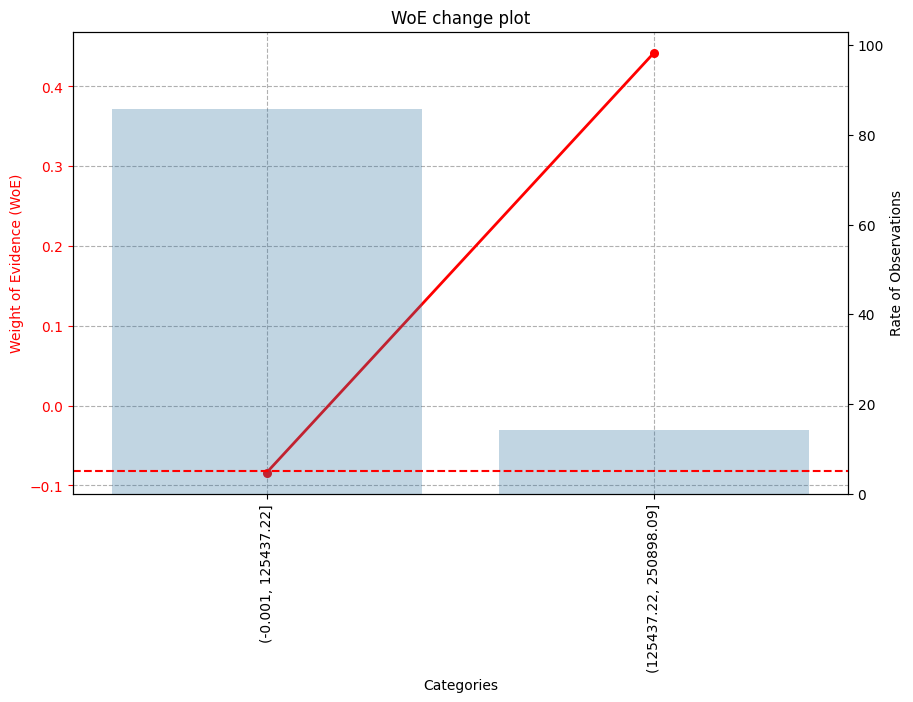

In [ ]:
bins = [-0.001, 125437.22, 250898.09]
train_df['Balance_NumOfProducts_cat'] = pd.cut(train_df['Balance_NumOfProducts'], bins=bins)
test_df['Balance_NumOfProducts_cat'] = pd.cut(test_df['Balance_NumOfProducts'], bins=bins)

woe_table = get_WoE(train_df, 'Balance_NumOfProducts_cat', 'Exited')
view_WoE(woe_table, cat='Balance_NumOfProducts_cat', plotly=False)

In [ ]:
dict_rank = woe_table.set_index('Balance_NumOfProducts_cat')['rank'].to_dict()
train_df['Balance_NumOfProducts_rank'] = train_df['Balance_NumOfProducts_cat'].map(dict_rank)
test_df['Balance_NumOfProducts_rank'] = test_df['Balance_NumOfProducts_cat'].map(dict_rank)

dict_woe = woe_table.set_index('Balance_NumOfProducts_cat')['WOE'].to_dict()
train_df['Balance_NumOfProducts_woe'] = train_df['Balance_NumOfProducts_cat'].map(dict_woe)
test_df['Balance_NumOfProducts_woe'] = test_df['Balance_NumOfProducts_cat'].map(dict_woe)

## start_age

In [ ]:
train_df['start_age'] = train_df['Age'] - train_df["Tenure"]
test_df['start_age'] = test_df['Age'] - test_df["Tenure"]

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



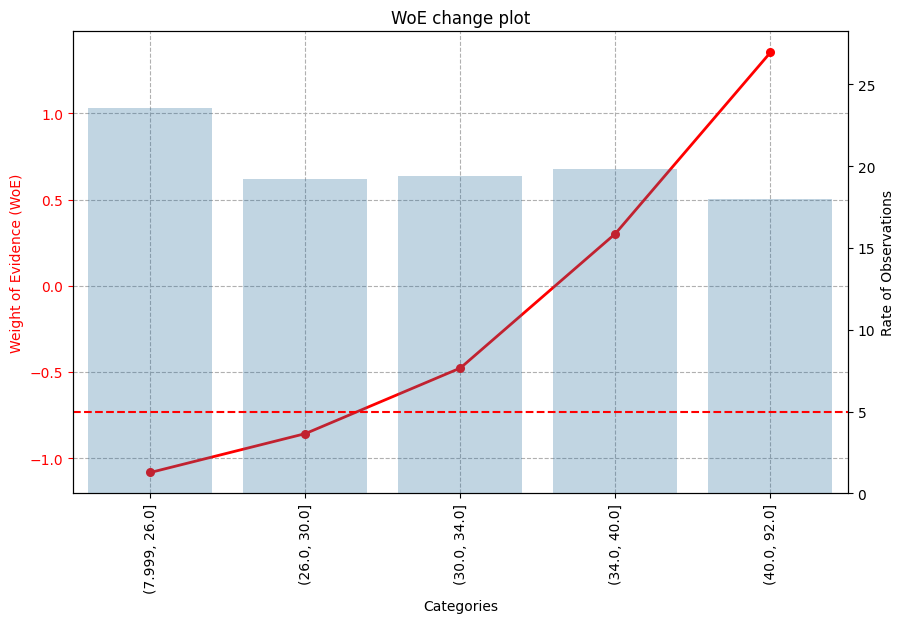

In [ ]:
bins = [7.999, 26.0, 30.0, 34.0, 40.0, 92.0]

train_df['start_age_cat'] = pd.cut(train_df['start_age'], bins=bins)
test_df['start_age_cat'] = pd.cut(test_df['start_age'], bins=bins)

woe_df = get_WoE(train_df, 'start_age_cat', 'Exited')
view_WoE(woe_df, cat='start_age_cat', plotly=False)

In [ ]:
dict_rank = woe_df.set_index('start_age_cat')['rank'].to_dict()
train_df['start_age_rank'] = train_df['start_age_cat'].map(dict_rank)
test_df['start_age_rank'] = test_df['start_age_cat'].map(dict_rank)

dict_woe = woe_df.set_index('start_age_cat')['WOE'].to_dict()
train_df['start_age_woe'] = train_df['start_age_cat'].map(dict_woe)
test_df['start_age_woe'] = test_df['start_age_cat'].map(dict_woe)

## Start year

In [ ]:
train_df['start_year'] = 2024 - train_df['Tenure']
test_df['start_year'] = 2024 - test_df['Tenure']

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



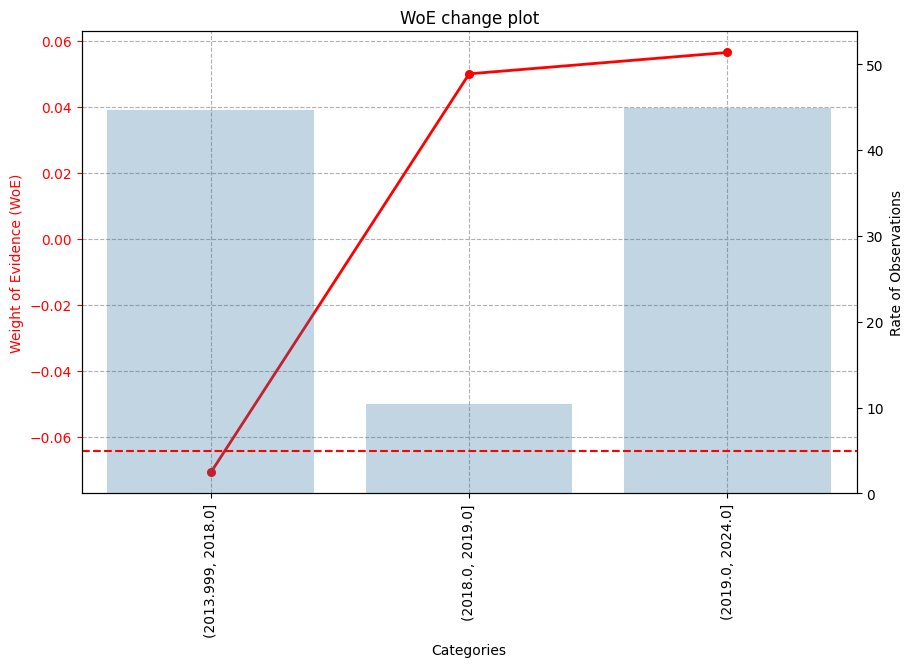

In [ ]:
# bins = [2013.999, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0, 2024.0]
bins = [2013.999, 2018.0, 2019.0, 2024.0]

train_df['start_year_cat'] = pd.cut(train_df['start_year'], bins=bins)
test_df['start_year_cat'] = pd.cut(test_df['start_year'], bins=bins)

woe_df = get_WoE(train_df, 'start_year_cat', 'Exited')
view_WoE(woe_df, cat='start_year_cat', plotly=False)

In [ ]:
dict_rank = woe_df.set_index('start_year_cat')['rank'].to_dict()
train_df['start_year_rank'] = train_df['start_year_cat'].map(dict_rank)
test_df['start_year_rank'] = test_df['start_year_cat'].map(dict_rank)


dict_woe = woe_df.set_index('start_year_cat')['WOE'].to_dict()
train_df['start_year_woe'] = train_df['start_year_cat'].map(dict_woe)
test_df['start_year_woe'] = test_df['start_year_cat'].map(dict_woe)

## new_balance

In [ ]:
train_df['new_balance'] = np.round(((train_df['Balance']+3) * (train_df['EstimatedSalary']+3)) / 100000000) + 1
test_df['new_balance'] = np.round(((test_df['Balance']+3) * (test_df['EstimatedSalary']+3)) / 100000000) + 1
bins = [-1.0, 58.0, 148.0, max(train_df['new_balance'].max(), test_df['new_balance'].max())]
train_df['new_balance_cat'] = pd.cut(train_df['new_balance'], bins=bins)
test_df['new_balance_cat'] = pd.cut(test_df['new_balance'], bins=bins)
new_woe_df = get_WoE(train_df, 'new_balance_cat', 'Exited')

new_rank_dict = new_woe_df.set_index('new_balance_cat')['rank'].to_dict()
train_df['new_balance_rank'] = train_df['new_balance_cat'].map(new_rank_dict)
test_df['new_balance_rank'] = test_df['new_balance_cat'].map(new_rank_dict)

woe_dict = new_woe_df.set_index('new_balance_cat')['WOE'].to_dict()
train_df['new_balance_woe'] = train_df['new_balance_cat'].map(woe_dict)
test_df['new_balance_woe'] = test_df['new_balance_cat'].map(woe_dict)

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-89-8900af3621a6>:100: UserWarning:

FixedFormatter should only be used together with FixedLocator



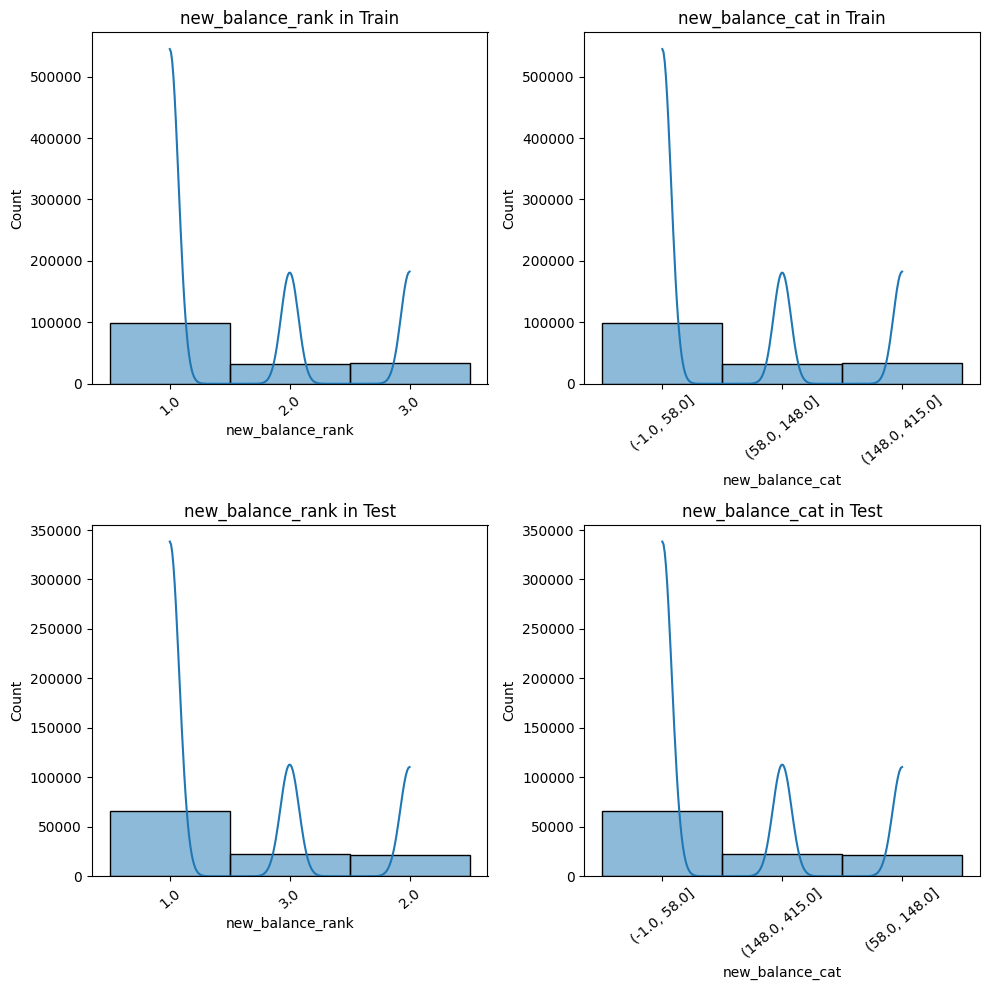

In [ ]:
plot_histograms(train_df, test_df, 'new_balance_cat', 'new_balance_rank')

<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



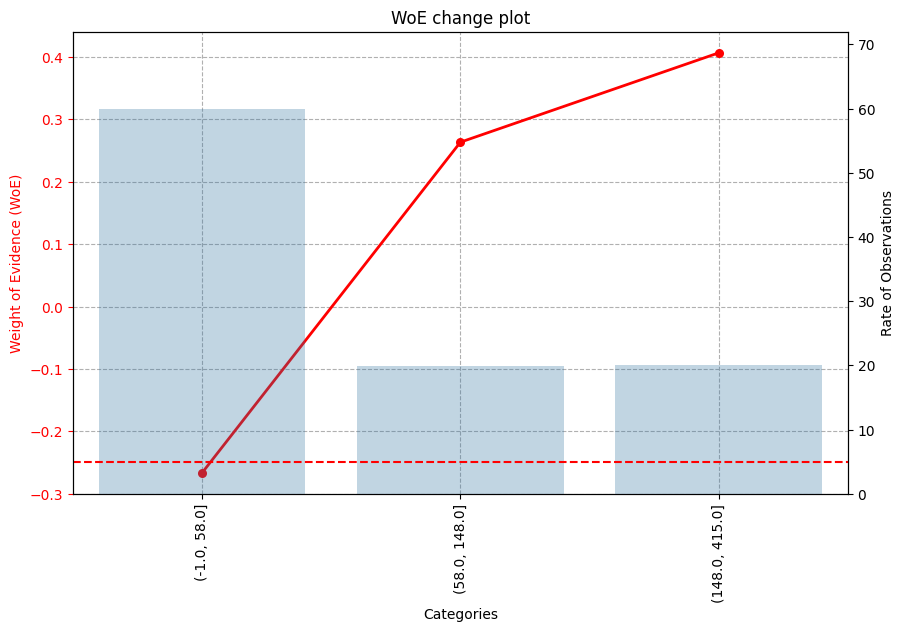

In [ ]:
woe_df = get_WoE(train_df, 'new_balance_cat', 'Exited')
view_WoE(woe_df, cat='new_balance_cat', plotly=False)

In [ ]:
rank_dict = woe_df.set_index('new_balance_cat')['rank'].to_dict()
train_df['new_balance_rank'] = train_df['new_balance_cat'].map(rank_dict)
test_df['new_balance_rank'] = test_df['new_balance_cat'].map(rank_dict)
train_df['new_balance_rank'] = pd.to_numeric(train_df['new_balance_rank'])
test_df['new_balance_rank'] = pd.to_numeric(test_df['new_balance_rank'])

woe_rank = woe_df.set_index('new_balance_cat')['WOE'].to_dict()
train_df['new_balance_woe'] = train_df['new_balance_cat'].map(woe_rank)
test_df['new_balance_woe'] = test_df['new_balance_cat'].map(woe_rank)
train_df['new_balance_woe'] = pd.to_numeric(train_df['new_balance_woe'])
test_df['new_balance_woe'] = pd.to_numeric(test_df['new_balance_woe'])

## Geo mean salary

In [ ]:
geo_mean_salary = train_df.groupby('Geography')['EstimatedSalary'].mean()
train_df['geo_mean_salary'] = train_df['Geography'].map(geo_mean_salary)
test_df['geo_mean_salary'] = test_df['Geography'].map(geo_mean_salary)

## Age p

In [ ]:
train_df['age_p'] = train_df['age_rank'] / train_df['Age']
test_df['age_p'] = test_df['age_rank'] / test_df['Age']

print(train_df['age_p'].isna().sum())
print(test_df['age_p'].isna().sum())

0
0


0
0
Series([], Name: age_p, dtype: float64)


<ipython-input-89-8900af3621a6>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



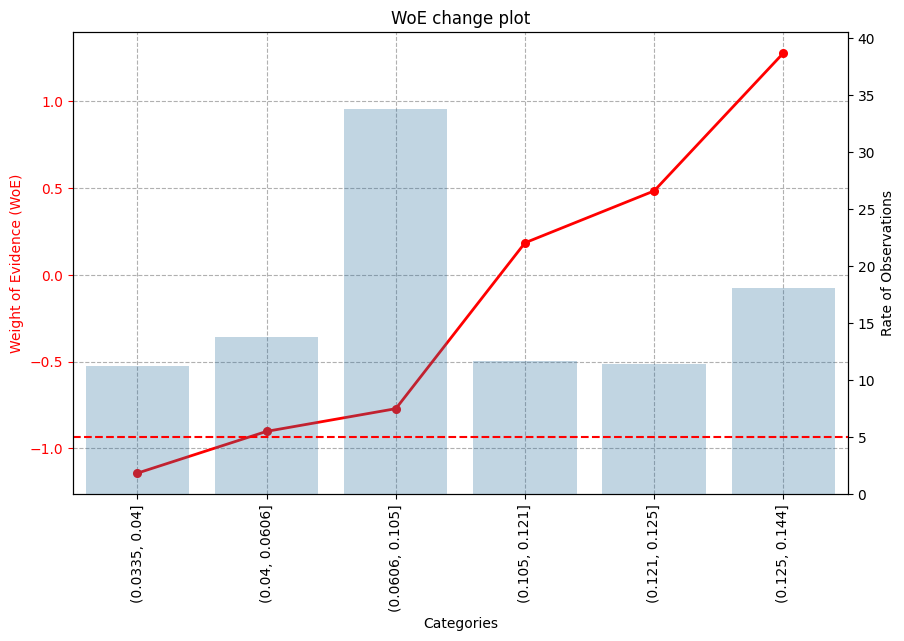

In [ ]:
bins = [0.0335, 0.04, 0.0606, 0.105, 0.121, 0.125, 0.144]
train_df['age_p_cat'] = pd.cut(train_df['age_p'], bins=bins)
test_df['age_p_cat'] = pd.cut(test_df['age_p'], bins=bins)

print(train_df['age_p_cat'].isna().sum())
print(test_df['age_p_cat'].isna().sum())
print(test_df[test_df['age_p_cat'].isna()]['age_p'])
woe_df = get_WoE(train_df, 'age_p_cat', 'Exited')
view_WoE(woe_df, cat='age_p_cat', plotly=False)

In [ ]:
dict_age_rank = woe_df.set_index('age_p_cat')['rank'].to_dict()
train_df['age_p_rank'] = train_df['age_p_cat'].map(dict_age_rank)
test_df['age_p_rank'] = test_df['age_p_cat'].map(dict_age_rank)

dict_age_woe = woe_df.set_index('age_p_cat')['WOE'].to_dict()
train_df['age_p_woe'] = train_df['age_p_cat'].map(dict_age_woe)
test_df['age_p_woe'] = test_df['age_p_cat'].map(dict_age_woe)

## balance_tenure

## Tenure_NumOfProducts

# Test

In [ ]:
train_df.head(1)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,start_year_woe,new_balance,new_balance_cat,new_balance_rank,new_balance_woe,geo_mean_salary,age_p,age_p_cat,age_p_rank,age_p_woe
0,15674932,Okwudilichukwu,668,0,0,33.0,3,0.0,2,1.0,...,0.056478,1.0,"(-1.0, 58.0]",1.0,-0.266454,112483.924571,0.060606,"(0.0606, 0.105]",3.0,-0.77174


- **Geography**: Mijoz yashaydigan mamlakat.
- **Gender**: Mijozning jinsi.
- **HasCrCard**: Kredit kartaga ega yoki yo‘qligi (1 = ega, 0 = ega emas).
- **IsActiveMember**: Faol a'zo yoki yo‘qligi (1 = faol, 0 = faol emas).
- **CreditScore**: Kredit balli.
- **Age**: Mijozning yoshi.
- **Tenure**: Bank bilan bo‘lgan yillar soni.
- **Balance**: Mijozning hisob balansidagi mablag‘.
- **NumOfProducts**: Mijoz foydalanayotgan bank mahsulotlari soni.
- ***EstimatedSalary***: Mijozning taxminiy daromadi.

In [ ]:
model_df = train_df.drop(columns=['Geography', 'age_cat', 'balance_cat',
                                  'credit_score_cat', 'tenure_cat', 'num_products_cat','Surname',
                                  'salary_cat', 'new_balance_cat',
                                  'Balance_NumOfProducts_cat', 'start_age_cat', 'age_p_cat', 'start_year_cat',
                                  'balance_tenure_cat'
                                  # 'balance_tenure_cat'
                                  # 'tenure_woe', 'salary_rank',
                                  # 'EstimatedSalary'
                                  ]).copy()
new_df = model_df.copy()
new_df.head(1)

,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,new_balance,new_balance_rank,new_balance_woe,geo_mean_salary,age_p,age_p_rank,age_p_woe,balance_tenure,balance_tenure_rank,balance_tenure_woe
0,15674932,668,0,33.0,3,0.0,2,1.0,0.0,181449.97,...,1.0,1.0,-0.266454,112483.924571,0.060606,3.0,-0.77174,0.025,3.0,-0.216939


Test Feature ingenering

## Modeling

### Test model

In [ ]:
feature = ['CustomerId', 'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
           'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'age_rank',
           'age_woe', 'geo_rank', 'geo_woe', 'credit_score_woe', 'tenure_rank',
           'salary_woe', 'new_balance', 'new_balance_rank', 'new_balance_woe',
           'age_p', 'Balance_NumOfProducts', 'start_year', 'geo_mean_salary',
           'Balance_NumOfProducts_rank', 'Balance_NumOfProducts_woe', 'start_age_rank',
           'start_year_rank', 'age_p_rank'
          #  'start_age_woe'
           ]
X = new_df.drop(columns=['Exited'])
# X = new_df[feature]
y = new_df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


simple_model = Pipeline([
    ('scaler', StandardScaler()),
    # ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression(max_iter=10000))
])

cros_rms = cross_val_score(simple_model, X_train, y_train, cv=5, scoring='roc_auc')

simple_model.fit(X_train, y_train)

y_pred = simple_model.predict(X_test)

y_score = simple_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_score)

print(f'ROC AUC CV: {np.mean(cros_rms)}')
print(f'ROC AUC: {roc_auc}')

### Model

#### Simple Model

In [ ]:
X = new_df.drop(columns=['Exited'])
# X = new_df[feature]
y = new_df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


final_simple_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression(max_iter=10000))
])

# cros_rms = cross_val_score(final_simple_model, X, y, cv=5, scoring='roc_auc')

final_simple_model.fit(X, y)

# y_pred = simple_model.predict(X_test)

# y_score = simple_model.predict_proba(X_test)[:, 1]

# roc_auc = roc_auc_score(y_test, y_score)

# print(f'ROC AUC CV: {np.mean(cros_rms)}')
# print(f'ROC AUC: {roc_auc}')

NameError: name 'cros_rms' is not defined

#### Submession

In [ ]:
test_pred = final_simple_model.predict_proba(test_df[X.columns])[:, 1]
test_df['Exited'] = test_pred
test_df[['id', 'Exited']].to_csv('submission.csv', index=False)

## Ensemble

In [ ]:
X = new_df.drop(columns=['Exited'])
y = new_df['Exited']

logistic_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression(max_iter=1000,
                                 penalty='l2',
                                 C=1))
])

ridge_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', RidgeClassifier())
])

base_learners = [
    ('rd', ridge_model),
    ('lr', logistic_model)

]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

meta_model = LogisticRegression(max_iter=1000,
                                 penalty='l2',
                                 C=1)

stacking_model = StackingClassifier(estimators=base_learners,
                                    final_estimator=meta_model)

ensemble_model = Pipeline([
    ('scaler', StandardScaler()),
    # ('poly', PolynomialFeatures(degree=2)),
    ('model', stacking_model)
])

# roc_cross = cross_val_score(model, X, y, cv=4, scoring='roc_auc')

ensemble_model.fit(X, y)

# y_pred = model.predict(X_test)
# y_score = model.predict_proba(X_test)[:, 1]

# roc_auc = roc_auc_score(y_test, y_score)
# accuracy = accuracy_score(y_test, y_pred)
# recoll = recall_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)

# print(f'ROC AUC CV: {np.mean(roc_cross)}')
# print(f'ROC AUC: {roc_auc}')
# print(f'Accuracy: {accuracy}')
# print(f'Recall: {recoll}')
# print(f'Precision: {precision}')

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 StackingClassifier(estimators=[('rd',
                                                 Pipeline(steps=[('scaler',
                                                                  StandardScaler()),
                                                                 ('poly',
                                                                  PolynomialFeatures()),
                                                                 ('model',
                                                                  RidgeClassifier())])),
                                                ('lr',
                                                 Pipeline(steps=[('scaler',
                                                                  StandardScaler()),
                                                                 ('poly',
                                                                  PolynomialFeatures()),
                                                                 ('model',
                                                                  LogisticRegression(C=1,
                                                                                     max_iter=1000))]))],
                                    final_estimator=LogisticRegression(C=1,
                                                                       max_iter=1000)))])

### #

In [ ]:
test_pred = simple_model.predict_proba(test_df[X.columns])[:, 1]
test_df['Exited'] = test_pred
test_df[['id', 'Exited']].to_csv('submission.csv', index=False)